# Predicting the Length of a British Monarch's Reign

In this workbook I'm gonna do some analysis on British Monarchs, and see if we can identify factors that contribute to a longer or shorter time on the throne. The meat of the analysis is using simple linear regression to identify the contribution of various factors.

In [1]:
# Importing all kinds of stuff

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import arrow
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


% matplotlib inline

## Importing and cleaning data

There's four csvs of data I'm importing, and they all need greater or lesser degrees of cleaning. A lot of the features I'm pulling out of these datasets were actually the result of lots of faffing around trying various things, but I've put them all together here.

In [2]:
# "Birth Dates" is the birth dates of various monarchs

birthdates = pd.read_csv('birth_dates.csv')
birthdates['days_parsed'] = birthdates.Days.apply(lambda x: x.replace(',', '')).astype('int')
birthdates.index = birthdates.Monarch.apply(lambda x: re.sub('King |Queen ', '', x)).values

In [3]:
# "Wars" is the dates of wars that ocurred on British soil

wars = pd.read_csv('wars.csv')

In [4]:
# "Temperatures" is the average temperature at 50-year intervals, 
# which I use for some ridiculous spurious correllations later.

temperatures = pd.read_csv('warm_period.txt', delimiter=' ')

# ugly little helper method
def snip_number(x, n):
    match = re.findall('(\d+)', x)
    if len(match) > n:
        return match[n]

temperatures['start'] = temperatures.year.apply(snip_number, args=(0,)).astype('int')
temperatures['end'] = temperatures.year.apply(snip_number, args=(1,)).astype('int')
temperatures['diff_from_mean'] = temperatures['adjusted_year'] - temperatures['adjusted_year'].mean()

In [5]:
# This is the juice: The reigns of each monarch since 1066 or so.

df = pd.read_csv('monarchs_cleaned.csv')

In [6]:
df['start_date_parsed'] = df.apply(lambda x: arrow.get(
                        x['Cleaned Start dates'] + ' ' + str(x['First regnal year']),
                         'D MMMM YYYY')
                                     , axis=1)
df['Age at ascension'] = (df.Monarch.map(birthdates['days_parsed'].to_dict()) / 365).apply(round)
df['Minor'] = (df['Age at ascension'] <= 14)*1
df['Woman'] = df.Monarch.apply(lambda x: any(i in x for i in ['Mary', 'Elizabeth', 'Victoria']))*1
df['previous reign'] = df['Cleaned Years'].shift(1).fillna(0)
df['Years since 1066'] = df['First regnal year'] - 1066

# Some of the data was in a weird format, so I just fix some of those by hand
df.iloc[0,11] = 38
df.iloc[1,11] = 31
df.iloc[5,11] = 31
df.iloc[8,11] = 19
df.iloc[27,11] = 38
df.iloc[28,11] = 38

In [7]:
# A bunch of badly-written helpers here for figuring out if there were any wrs around the time the monarch took power. 

def on_or_between(row, year):
    if pd.isnull(row.end):
        return year >= int(row.start) and year <= int(row.start)
    else:
        return year > int(row.start) and year <= int(row.end)
    
def near(row, year):
    if pd.isnull(row.end):
        return year >= int(row.start) -3 and year <= int(row.start)
    else:
        return year > int(row.start) -3 and year <= int(row.end)

def any_wars(year, func):
    return wars.apply(func, axis=1, args=(year,)).any()

def any_civil_wars(year, func):
    return wars[wars.Notes == 'Civil war'].apply(func, axis=1, args=(year,)).any()
    
df['civil war during ascencion'] = df['First regnal year'].apply(any_civil_wars, args=(on_or_between,))*1
df['war during ascencion'] = df['First regnal year'].apply(any_wars, args=(on_or_between,))*1
df['war near ascencion'] = df['First regnal year'].apply(any_wars, args=(near,))*1

In [8]:
# Getting the average temperature at the time the monarch took the throne.

mask = temperatures.apply(lambda r: df['First regnal year'].between(r.start, r.end), axis=1).T
df['temperature'] = mask.dot(mask.columns).apply(lambda x: temperatures.adjusted_year[x] if x > 0 else 9.41)
df.temperature = df.temperature-df.temperature.mean()

In [9]:
# This is a bit overcomplicated: I'm pivoting out the "claim" column, 
# which is a text field with, like, "inherited", "usurped", etc. in it,
# and turning it into a bunch of columns, one for each category, and containing ones and zeroes.
# I bet there's a less obscure way of doing this.

chocula = CountVectorizer()

chocula.fit(df.Claim)

df = df.join(pd.DataFrame(chocula.transform(df.Claim).toarray(), columns=chocula.get_feature_names()))

In [10]:
# Let's have a look at an example of a single monarch from our final data set

df.loc[0]

Monarch                                       William I
No. of Years                                         21
First regnal year                                  1066
Regnal year start date                       14 October
Regnal year end date                         13 October
End of final year                            9 Sep 1087
Cleaned Years                                        21
Cleaned Start dates                          14 October
Cleaned end date                             9 Sep 1087
Claim                                          conquest
start_date_parsed             1066-10-14T00:00:00+00:00
Age at ascension                                     38
Minor                                                 0
Woman                                                 0
previous reign                                        0
Years since 1066                                      0
civil war during ascencion                            0
war during ascencion                            

## Some Summary Statistics

I'll start out with some basic description of the dataset and look for patterns or basic correllations in the data.

In [12]:
# Describing some of the numeric columns

df[['Cleaned Years', 'Age at ascension', 'temperature']].describe()

,Cleaned Years,Age at ascension,temperature
count,41.000000,41.000000,4.100000e+01
mean,23.560976,30.975610,-5.199093e-16
std,17.903978,14.547316,4.570771e-01
min,1.000000,1.000000,-6.217073e-01
25%,10.000000,22.000000,-3.217073e-01
50%,20.000000,31.000000,-8.170732e-02
75%,35.000000,38.000000,1.782927e-01
max,65.000000,65.000000,8.782927e-01


In [14]:
df.Woman.value_counts()

0    36
1     5
Name: Woman, dtype: int64

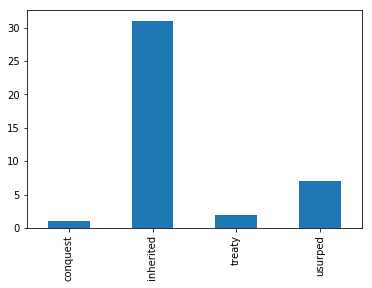

In [213]:
# How monarchs took the throne

df[['conquest', 'inherited', 'treaty', 'usurped']].sum().plot(kind='bar')
plt.show()

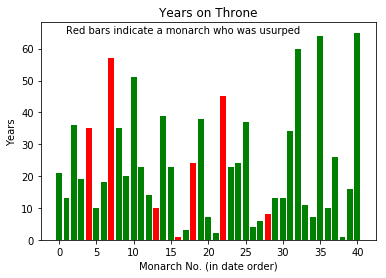

In [250]:
# Patterns over time, plus how monarchs took the throne

cmap = df['usurped'].shift(1).fillna(0).astype(int).map({0:'green', 1:'red'})

plt.bar(df.index, df['Cleaned Years'], color=cmap)
plt.title('Years on Throne')
plt.ylabel('Years')
plt.xlabel('Monarch No. (in date order)')
plt.annotate('Red bars indicate a monarch who was usurped', (1, 65))
plt.show()

In [195]:
# Corellations between various features and time on the throne.

cols = df.columns[11:]
for col in cols:
    corr = float(df[col].corr(df['Cleaned Years']))
    print(col, int(round(corr*100)))

('Age at ascension', -48)
('Minor', 10)
('Woman', 47)
('previous reign', -16)
('Years since 1066', -9)
('civil war during ascencion', 6)
('war during ascencion', -10)
('war near ascencion', -16)
('temperature', 26)
(u'conquest', -1)
(u'inherited', 16)
(u'treaty', -1)
(u'usurped', -16)


We can see in the cell above that there are a few features that are strongly correllated with the length of a monarch's reign. "Age at ascencion" is an obvious one, as is inheriting the throne, rather than usurping it. But there are other correllations which are a little more surprising. Being a woman improves your odds of a long reign. The most interesting correllation, for me, was the link between averge tempertures and a long, peaceful reign.

We'll tease out more details of this in the next section.

## Regression Analysis

Using linear regression to understand the relationships between some features

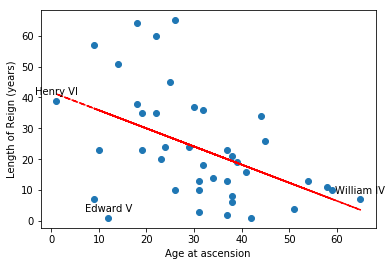

In [24]:
# The biggest single influence on length of reign is age at ascension. Here we plot that relationship.

x = df['Age at ascension']
y = df['Cleaned Years']

plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

for label, x, y in zip(df.Monarch, x, y):
    if x < 5 or x > 60 or (y < 3 and x < 15):
        plt.annotate(
        label,
        xy = (x, y+2),
        ha = 'center'
        )

plt.xlabel('Age at ascension')
plt.ylabel('Length of Reign (years)')

plt.savefig('age.png')
plt.show()

In [26]:
# There's some outliers though - some young monarchs that ruled for a short time. 
# Let's see the effect of taking the throne very young/ 

lino = LinearRegression()

cols = ['Age at ascension', 'Minor']

lino.fit(df[cols], df['Cleaned Years'].values.reshape(-1,1))

for feature, coef in zip(cols, lino.coef_[0]):
    print(feature, coef)

('Age at ascension', -0.78690795498389365)
('Minor', -12.951243707088514)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


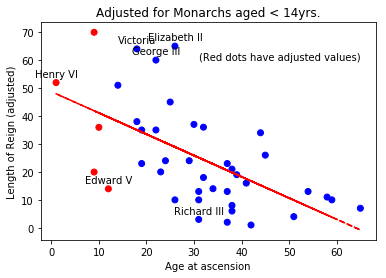

In [28]:
# Looks like taking the throne under the age of 14 knocks about 13 years off your expected reign.
# Let's look at the chart again, adjusting for this effect.

x = df['Age at ascension']

y = df['Cleaned Years'] - ((df['Age at ascension'] < 14) * lino.coef_[0][1])

plt.scatter(x, 
            y,
            c = (df['Age at ascension'] < 14).map({False:'blue', True:'red'})
           )

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

label_names = ['Henry VI', 'William V', 'Richard III', 'Edward V', 'George III', 'Victoria', 'Elizabeth II']

for label, x, y, pred_y in zip(df.Monarch, x, y, lino.predict(df[['Age at ascension', 'Minor']])):
    if label in label_names:
        plt.annotate(
        label,
        xy = (x, y+2),
        ha = 'center'
        )
plt.title('Adjusted for Monarchs aged < 14yrs.')
plt.xlabel('Age at ascension')
plt.ylabel('Length of Reign (adjusted)')
plt.annotate('(Red dots have adjusted values)', (65, 60), ha='right')
plt.savefig('age_adjusted.png')
plt.show()

### Temperature

One of the interesting correllations we saw was between average temperatures and length of reign. In this section I'll look at how temperature changes due to the "Medieval Warm Period" align with variance from an "expected length of reign" generated from the model we created above.

In [270]:
predictions = pd.Series([i[0] for i in lino.predict(df[['Age at ascension', 'Minor']])])

In [271]:
def year_temp(year):
    try:
        return temperatures[(temperatures.start <= year) & (temperatures.end > year-1)].diff_from_mean.values[0]
    except:
        return 0.06


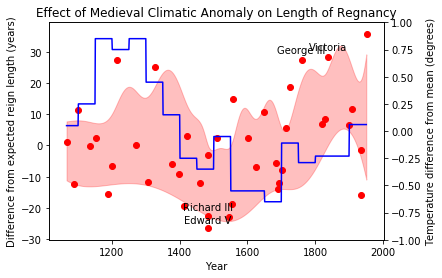

In [272]:
x = df['First regnal year'] + (df['First regnal year'].rank(method='first')/1000)
y = df['Cleaned Years'] - predictions

y_mean = y.rolling(6).mean()
y_low = y_mean - y.rolling(6).std()

y_low_smooth = UnivariateSpline(x, y_low.fillna(y_low[5]), k=4, s=200)(range(1066,1952))
y_high = y_mean + y.rolling(6).std()
y_high_smooth = UnivariateSpline(x, y_high.fillna(y_high[5]), k=4, s=200)(range(1066,1952))


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.fill_between(range(1066,1952), y_high_smooth, y_low_smooth, color='red', alpha=0.25)
ax1.scatter(
        x=x,
        y=y,
        c='red')

ax2.plot(range(1066,1952), 
            pd.Series(range(1066,1952)).apply(year_temp),
         c='blue'
           )
ax2.set_ylim([-1,1])

for label, x, y in zip(df.Monarch, x, y):
    if label in ['Richard III', 'Edward V', 'George III', 'Victoria']:
        ax1.annotate(
        label,
        xy = (x, y+(x/900)),
        ha = 'center'
        )

ax1.set_xlabel('Year')
ax1.set_ylabel('Difference from expected reign length (years)')
ax2.set_ylabel('Temperature difference from mean (degrees)')
plt.title('Effect of Medieval Climatic Anomaly on Length of Regnancy')

plt.savefig('temp_error_correllation.png', bbox_inches='tight')
plt.show()

## Final Model

Let's make a model that tries to predict how long a monarch will reign. We'll use some of the features we explored previously. 

In [274]:
train, test = train_test_split(df, test_size = 0.2)
linus = LinearRegression()
features = ['Minor', 'Age at ascension', 'Years since 1066', 'temperature', 'usurped']
linus.fit(train[features], train['Cleaned Years'])
predictions = linus.predict(test[features])

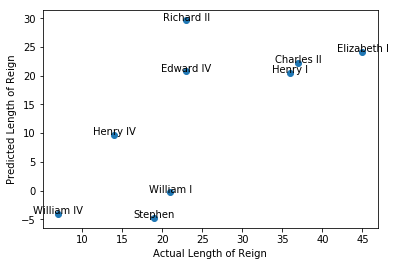

In [275]:
plt.scatter(
    test['Cleaned Years'],
    predictions  
    )

for label, x, y in zip(test.Monarch, test['Cleaned Years'], predictions):
        plt.annotate(
        label,
        xy = (x, y),
        ha = 'center'
        )

plt.ylabel('Predicted Length of Reign')
plt.xlabel('Actual Length of Reign')
plt.savefig('predicted_vs_actual_test.png', bbox_inches='tight')
plt.show()

So our model is not exactly _super_ accurate, but it does ok?

In [280]:
# Here's the coeficients for each of our features. 
# A neat thing about linear regression is that the coeficients are in the same units as the value we're predicting.
# That means we can translate directly from the coeficients 
# to a number of years added or subtracted from a monarch's reign.

print("Baseline: ", linus.intercept_)
for feature, coef_ in zip(features, linus.coef_):
    print(feature, round(coef_, 2))

('Minor', -14.99)
('Age at ascension', -1.1)
('Years since 1066', 0.04)
('temperature', 15.96)
('usurped', -9.31)
